# SAR Training Workshop for Forest Applications

# HOW TO MAKE RGB COMPOSITES FROM DUAL-POLARIMETRIC DATA

Josef Kellndorfer, Ph.D., President and Senior Scientist, Earth Big Data, LLC

Revision date: January 2018

In this chapter we introduce how to make a three band color composite and save it

# Import Python modules

In [8]:
import os,sys
import gdal
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.patches as patches  # Needed to draw rectangles
from skimage import exposure # to enhance image display
import numpy as np
import pandas as pd

# Select the Project data set and time series data

In [9]:
## Peru - Yurimaguas
#prefix='/dev/shm/projects/'
prefix='/Users/amenaza/github/servir_2019/Data/'
datapath='Peru/S32718X350000Y9353000sS1_EBD/'
datefile_like='S32718X350000Y9323000sS1_D_vv_0069_mtfil.dates'
datefile_cross='S32718X350000Y9323000sS1_D_vh_0069_mtfil.dates'
imagefile_like='S32718X350000Y9323000sS1_D_vv_0069_mtfil.vrt'
imagefile_cross='S32718X350000Y9323000sS1_D_vh_0069_mtfil.vrt'
datefile=datefile_like
imagefile=imagefile_like
os.chdir(os.path.join(prefix,datapath))

We are defining two helper functions for this task

- **CreateGeoTiff()** to write out images
- **dualpol2rgb()** to compute various metrics from a time series data stack

In [10]:
def CreateGeoTiff(Name, Array, DataType, NDV,bandnames=None,ref_image=None, 
                  GeoT=None, Projection=None):
    # If it's a 2D image we fake a third dimension:
    if len(Array.shape)==2:
        Array=np.array([Array])
    if ref_image==None and (GeoT==None or Projection==None):
        raise RuntimeWarning('ref_image or settings required.')
    if bandnames != None:
        if len(bandnames) != Array.shape[0]:
            raise RuntimeError('Need {} bandnames. {} given'
                               .format(Array.shape[0],len(bandnames)))
    else:
        bandnames=['Band {}'.format(i+1) for i in range(Array.shape[0])]
    if ref_image!= None:
        refimg=gdal.Open(ref_image)
        GeoT=refimg.GetGeoTransform()
        Projection=refimg.GetProjection()
    driver= gdal.GetDriverByName('GTIFF')
    Array[np.isnan(Array)] = NDV
    DataSet = driver.Create(Name, 
            Array.shape[2], Array.shape[1], Array.shape[0], DataType)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection)
    for i, image in enumerate(Array, 1):
        DataSet.GetRasterBand(i).WriteArray( image )
        DataSet.GetRasterBand(i).SetNoDataValue(NDV)
        DataSet.SetDescription(bandnames[i-1])
    DataSet.FlushCache()
    return Name

In [11]:
def dualpol2rgb(like,cross,sartype='amp',ndv=0):
    CF=np.power(10.,-8.3)
    if np.isnan(ndv):
        mask=np.isnana(cross)
    else:
        mask=np.equal(cross,ndv)    
    
    l = np.ma.array(like,mask=mask,dtype=np.float32)
    c = np.ma.array(cross,mask=mask,dtype=np.float32)
    
    if sartype=='amp':
        l=np.ma.power(l,2.)*CF
        c=np.ma.power(l,2.)*CF  
    elif sartype=='dB':
        l=np.ma.power(10.,l/10.)
        c=np.ma.power(10.,c/10.)
    elif sartype=='pwr':
        pass
    else:
        print('invalid type ',sartype)
        raise RuntimeError
      
    if sartype=='amp':
        ratio=np.ma.sqrt(l/c)/10
        ratio[np.isinf(ratio.data)]=0.00001
    elif sartype=='dB':
        ratio=10.*np.ma.log10(l/c)
    else:
        ratio=l/c

    ratio=ratio.filled(ndv)
    
    rgb=np.dstack((like,cross,ratio.data))

    
    bandnames=('Like','Cross','Ratio')
    return rgb,bandnames,sartype


def any2amp(raster,sartype='amp',ndv=0):
    CF=np.power(10.,-8.3)
    mask=raster==ndv
    
    if sartype=='pwr':
        raster=np.sqrt(raster/CF)
    elif sartype=='dB':
        raster=np.ma.power(10.,(raster+83)/20.)
    elif sartype=='amp':
        pass
    else:
        print('invalid type ',sartype)
        raise RuntimeError
    
    raster[raster<1]=1
    raster[raster>65535]=65535
    raster[mask]=0
    raster=np.ndarray.astype(raster,dtype=np.uint16)
    return raster

## Set the Dates

In [12]:
# Get the date indices via pandas
dates=open(datefile).readlines()
tindex=pd.DatetimeIndex(dates)
j=1
print('Bands and dates for',imagefile)
for i in tindex:
    print("{:4d} {}".format(j, i.date()),end=' ')
    j+=1
    if j%5==1: print()

Bands and dates for S32718X350000Y9323000sS1_D_vv_0069_mtfil.vrt
   1 2017-01-09    2 2017-02-02    3 2017-02-26    4 2017-03-10    5 2017-04-03 
   6 2017-04-15    7 2017-04-27    8 2017-05-09    9 2017-05-21   10 2017-06-02 
  11 2017-06-14   12 2017-06-26   13 2017-07-08   14 2017-07-20   15 2017-08-01 
  16 2017-08-13   17 2017-08-25   18 2017-09-06   19 2017-09-18   20 2017-09-30 
  21 2017-10-12   22 2017-10-24   23 2017-11-05   24 2017-11-17   25 2017-11-29 
  26 2017-12-11   27 2017-12-23   28 2018-01-04   29 2018-01-16   30 2018-01-28 
  31 2018-02-09   32 2018-02-21   33 2018-03-05   34 2018-03-17   35 2018-03-29 
  36 2018-04-10   37 2018-04-22   38 2018-05-04   39 2018-05-16   40 2018-05-28 
  41 2018-06-09   42 2018-10-31   43 2018-11-12   44 2018-11-24   45 2018-12-06 
  46 2018-12-18   47 2018-12-30   48 2019-01-11   49 2019-01-23   50 2019-02-04 
  51 2019-02-16   52 2019-03-12   53 2019-03-24   54 2019-04-17   55 2019-04-29 
  56 2019-05-11   57 2019-05-23   58 2019-05

In [13]:
# PICK A BAND NAUMBER
bandnbr=1
#bandnbr=1 

Open the image and get dimensions (bands,lines,pixels):

In [14]:
img_like=gdal.Open(imagefile_like)
img_cross=gdal.Open(imagefile_cross)
# Get Dimensions
print('Likepol ',img_like.RasterCount,img_like.RasterYSize,img_like.RasterXSize)
print('Crosspol',img_cross.RasterCount,img_cross.RasterYSize,img_cross.RasterXSize)

Likepol  69 1500 1500
Crosspol 69 1500 1500


For a managable size for this notebook we choose a 1000x1000 pixel subset to read the entire data stack. We also convert the amplitude data to power data right away and will perform the rest of the calculations on the power data to be mathmatically correct. NOTE: Choose a different xsize/ysize in the subset if you need to.

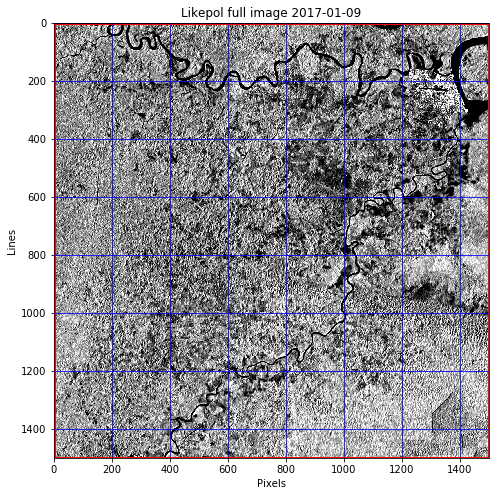

In [15]:
subset=None
#subset=(3500,1000,500,500)   # (xoff,yoff,xsize,ysize)
if subset==None:
    subset=(0,0,img_like.RasterXSize,img_like.RasterYSize)

raster=img_like.GetRasterBand(bandnbr).ReadAsArray()
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Likepol full image {}'
             .format(tindex[bandnbr-1].date()))
ax.imshow(raster,cmap='gray',vmin=np.nanpercentile(raster,5),vmax=np.nanpercentile(raster,95))
ax.grid(color='blue')
ax.set_xlabel('Pixels')
ax.set_ylabel('Lines')
# plot the subset as rectangle
if subset != None:
    _=ax.add_patch(patches.Rectangle((subset[0],subset[1]),
                                     subset[2],subset[3],
                                     fill=False,edgecolor='red',
                                     linewidth=3))

# MAKE THE RGB like/cross/ratio Image

In [16]:
raster_like=img_like.GetRasterBand(bandnbr).ReadAsArray(*subset)
raster_cross=img_cross.GetRasterBand(bandnbr).ReadAsArray(*subset)

We make an RGB stack to display the like,cross, and ratio data as a color composite.

In [17]:
rgb,bandnames,sartype=dualpol2rgb(raster_like,raster_cross)

We are interested in displaying the image enhanced with histogram equalization. 
We can use the function *exposure.equalize_hist()* from the skimage.exposure module

In [18]:
rgb_stretched=np.ndarray.astype(rgb.copy(),'float32')
# For each band we apply the strech
for i in range(rgb_stretched.shape[2]):
    rgb_stretched[:,:,i] = np.ndarray.astype(exposure.equalize_hist(rgb_stretched[:,:,i],
    mask=~np.equal(rgb_stretched[:,:,i],0)),'float32')

In [19]:
rgb_stretched


array([[[0.9290501 , 0.86765474, 0.13736178],
        [0.97709477, 0.94022894, 0.05379217],
        [0.9238519 , 0.83830774, 0.14354227],
        ...,
        [0.56944376, 0.5873967 , 0.538552  ],
        [0.96400297, 0.98231775, 0.0856656 ],
        [0.97853124, 0.99263585, 0.04953445]],

       [[0.9360179 , 0.86909807, 0.12934522],
        [0.9628124 , 0.9438962 , 0.08776738],
        [0.8793414 , 0.7964521 , 0.21381669],
        ...,
        [0.49837103, 0.66660887, 0.6034743 ],
        [0.8931233 , 0.9636245 , 0.19524239],
        [0.9565289 , 0.9876903 , 0.09899928]],

       [[0.96102655, 0.8998895 , 0.09093563],
        [0.98198974, 0.9532277 , 0.04385273],
        [0.9559336 , 0.8585139 , 0.10007565],
        ...,
        [0.7872115 , 0.90565234, 0.32265392],
        [0.9379036 , 0.971015  , 0.12707588],
        [0.93292105, 0.9673824 , 0.13289377]],

       ...,

       [[0.6789336 , 0.9394431 , 0.4372968 ],
        [0.8904505 , 0.99098945, 0.19888286],
        [0.86959964, 0

Now let's display the the histograms and equalized image side by side.

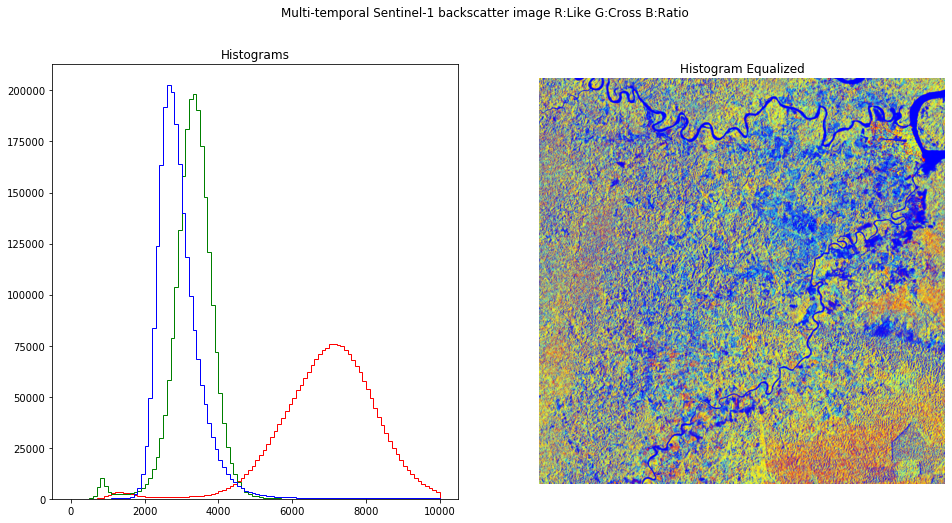

In [20]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
fig.suptitle('Multi-temporal Sentinel-1 backscatter image R:{} G:{} B:{}'
             .format(bandnames[0],bandnames[1],bandnames[2]))
plt.axis('off')
ax[0].hist(rgb[:,:,0].flatten(),histtype='step',color='red',bins=100,range=(0,10000))
ax[0].hist(rgb[:,:,1].flatten(),histtype='step',color='green',bins=100,range=(0,10000))
ax[0].hist(rgb[:,:,2].flatten(),histtype='step',color='blue',bins=100,range=(0,10000))
ax[0].set_title('Histograms')
ax[1].imshow(rgb_stretched,interpolation='bilinear')
ax[1].set_title('Histogram Equalized')
_=ax[1].axis('off')

# Write  the images to an output file

## Determine output geometry 

First, we need to set the correct geotransformation and projection information. We retrieve the values from the input images and adjust by the subset:

In [21]:
proj=img_like.GetProjection()
geotrans=list(img_like.GetGeoTransform())

subset_xoff=geotrans[0]+subset[0]*geotrans[1]  
subset_yoff=geotrans[3]+subset[1]*geotrans[5] 
geotrans[0]=subset_xoff
geotrans[3]=subset_yoff
geotrans=tuple(geotrans)
geotrans

(350000.0, 20.0, 0.0, 9353000.0, 0.0, -20.0)

### Build a like/cross/ratio amplitude scaled  GeoTIFF images

In [22]:
outbands=[]
for i in range(3):
    outbands.append(any2amp(rgb[:,:,i]))

imagename=imagefile_like.replace('_vv_','_lcr_').replace('.vrt','_{}.tif'.format(dates[bandnbr-1].rstrip()))
bandnames=['Like','Cross','Ratio']
Array=np.array(outbands)
CreateGeoTiff(imagename,Array,gdal.GDT_UInt16,0,bandnames,GeoT=geotrans,Projection=proj)

'S32718X350000Y9323000sS1_D_lcr_0069_mtfil_20170109.tif'

This Image can now be loaded into QGIS or other Tools 

# Exercise
Change the bandnbr, generate a new rgb image and export it. Display in QGIS.